In [3]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Most important package
import numpy as np

# The reinforcement learning environment
from gridworld import GridWorld

# Configure nice figures
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(14,7)

### ***! IMPORTANT NOTE !***

Your implementation should only use the `numpy` (`np`) module. The `numpy` module provides all the functionality you need for this assignment and makes it easier debuging your code. No other modules, e.g. `scikit-learn` or `scipy` among others, are allowed and solutions using modules other than `numpy` will be sent for re-submission. You can find everything you need about `numpy` in the official [documentation](https://numpy.org/doc/stable/).

---
## **1. Reinforcement Learning**
Reinforcement learning, or RL for short, does not work with inputs and targets, but instead learns by performing **actions** in an **environment** and observing the generated **rewards**.

RL is a very broad concept and many different algorithms have been deviced based on these general concepts of actions and rewards. Perhaps the main advantage of RL over other machine learning techniques is that we do not explicitly tell the model what the right answer is (like we have done in the previous assignments), but instead only tell the model when the desired outcome has been acheived. This might seem like the same thing at first, but the key difference is that RL allows the model to device solutions that outperform the human teacher. This is usually not possible in traditional supervised learning since the model can only get as good as the training data (the teacher). With the freedom to explore new strategies, which is inherent to RL, this is no longer true and some truly astounding results have been acheved. The most famous example is probably AlphaGo, the first computer program to beat a human expert in the board game Go. 


### **1.1 The environment interface**


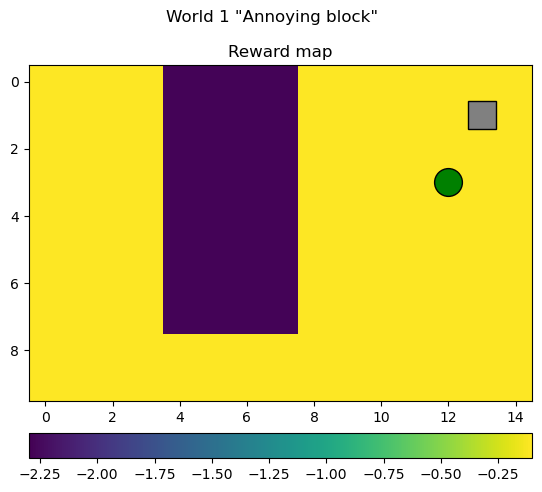

In [4]:
W = GridWorld(1)
W.init()
W.draw()

#### **<span style="color:red">Question 1:</span>**
The colored background represents the reward for entering each state. Notice that all rewards are negative. Can you think of why this is important?

#### **<span style="color:green">Answer:</span>**
\[ In Q-learning, the goal is to maximize the total reward. And the negative rewards means punishment. So it encourage the AI to identify the shortest path to the goal by minimizing its punishment.
The main reason that we use negative reward is that if we were to use positive rewards, then the agent could simply drive around on them forever and accumulate a very large accumulative reward even if it never reachs the goal. By using negative rewards, the agent receives a small punishment for each step that it takes, and so to minimize its punishments, it will try to reach the item shipping location by taking the fewer steps possible from its current location. The result, of course, will be the shortest path from the current location to the goal.\]

The **Agent** is represented by the gray square, and will traverse the environment in order to reach the **goal** state, represented by the green circle.
You can access all information you need regarding the state of the GridWorld by the methods of the World class. Here is the full list with explanations for each method:

* `getWorldSize()` - Returns a tuple with the size of each dimension in the state space. For the GridWorlds, this is the y-size and x-size of the grid.
* `getDimensionNames()` - Returns a list with the names for each dimension. This is only used to understand the world better, and should not be used to design the algorithm.
* `getActions()` - Returns a list of available actions in the form of strings. These are the only accepted values to pass to `doAction`.
* `init()` - Initializes the World. For example this resets the position of the agent in the GridWorlds. Do this at the beginning of each epoch.
* `getState()` - Returns the current state of the World, which for a GridWorld is the position of the agent.
* `doAction(act)` - Performs an action and returns a 2-tuple indicating if the actions was valid, and the corresponding reward.
* `draw(epoch, Q)` - Update any plots associated with the World. The two arguments are optional but will include more information in the plots if you provide them.

Here are some examples:

In [5]:
W = GridWorld(1)
print("World size:", W.getWorldSize())
print("Dimension names:", W.getDimensionNames())
print("Actions:", W.getActions())

World size: (10, 15)
Dimension names: ['Y', 'X']
Actions: ['Down', 'Up', 'Right', 'Left']


Here is an example of some actions in the first GridWorld. Read the code and output and make sure you understand how this works before proceeding. You can quickly run the cell multiple times by holding `Ctrl` and pressing `Enter` to generate a new output.

In [6]:
W = GridWorld(1)
W.init()

# Check state
state, isTerm = W.getState()
print(f"State initialized to {state}.")

# Make action
a = W.getActions()[1]
isValid, reward = W.doAction(a)
print(f"Action '{a}' was {'' if isValid else 'not '}valid and gave a reward of {reward}.")

# Check state
state, isTerm = W.getState()
print(f"State is {state} and is {('' if isTerm else 'not ')}terminal.")

# Make action
a = "Right"
isValid, reward = W.doAction(a)
print(f"Action '{a}' was {'' if isValid else 'not '}valid and gave a reward of {reward}.")

# Check state
state, isTerm = W.getState()
print(f"State is {state} and is {('' if isTerm else 'not ')}terminal.")

State initialized to (8, 9).
Action 'Up' was valid and gave a reward of -0.1.
State is (7, 9) and is not terminal.
Action 'Right' was valid and gave a reward of -0.1.
State is (7, 10) and is not terminal.


---
## **2. Implementing the Q-learning algorithm**
 **Q-learning** is powerful since it allows the simultaneous exploration of different **policies**. This is done by a state-action table **Q**, keeping track of the expected reward associated with each action in each state. By iteratively updating these estimates as we get new rewards, the policies explored by the agent eventually converges to the optimal policy. This can all be summarized in the following equation:

$$ \large Q\left(s_t,a\right) \leftarrow \underbrace{Q\left(s_t,a\right)}_{\mathrm{Old \space value}} \cdot \left(1-\alpha\right) + \alpha \cdot \underbrace{\left(r + \gamma V\left(s_{t+1}\right)\right)}_{\mathrm{New \space estimate}} $$

This defines that the value of $Q$ in a state $s_t$ for action $a$, i.e $Q\left(s_t,a\right)$, should be updated as a weighted average of the old value and a new estimate, where the weighting is based on the learning rate $\alpha \in (0,1)$. The new estimate is a combination of the reward $r$ for the action we are updating, and the estimated value $V$ of the next state $s_{t+1}$, discounted by the factor $\gamma \in (0,1]$. By increasing $\gamma$, the future value is weighted higher, which is why we say that this optimizes for long-term rewards.

### **2.1 The training function**
First, you will implement the Q-learning algorithm training loop in the following function. The inputs to this function is a World object, and a dictionary for any parameters needed for the training. This dictionary will contain the following parameters, which you will need `params = {"Epochs": 100, "MaxSteps": 100: "Alpha": 0.5: "Gamma": 0.9, "ExpRate": 0.5, "DrawInterval": 100}`. 

In [7]:
import numpy as np
from matplotlib import pyplot as plt


def getpolicy(Q):
    """ Get best policy matrix from the Q-matrix.
    You have to implement this function yourself. It is not necessary to loop
    in order to do this, and looping will be much slower than using matrix
    operations. It's possible to implement this in one line of code.
    """

    P = np.argmax(Q, axis = 2)

    return P


def getvalue(Q):
    """ Get best value matrix from the Q-matrix.
    You have to implement this function yourself. It is not necessary to loop
    in order to do this, and looping will be much slower than using matrix
    operations. It's possible to implement this in one line of code.
    """
    
    V = np.max(Q, axis = 2)

    return V





def QLearning(World, params={}):
    
    # Init world and get size of dimensions
    WSize = World.getWorldSize()
    A = World.getActions()
    NA = len(A)

    
    # Initialize the Q-matrix (use the size variables above)
    Q = np.zeros((WSize[0],WSize[1],NA))
    
    for i in range(params["Epochs"]):
        #init a start state
        # At the biginning of each epoch, we reset the World
        World.init()
        state, isTerm = World.getState()
        for j in range(params["MaxSteps"]):
        # Check state
        # to check the init state is not terminal state
        # Make action
        #define epsilon greedy algorithm
            if np.random.random()<params["Eps"]:
                m= np.random.randint(NA)
            else:
                #m= getpolicy(Q)[state[0], state[1]]
                m=np.argmax(Q[state[0], state[1]])
         # check
        # Make action
            a = A[m]
            isValid, reward = World.doAction(a)
            next_state, isTerm = World.getState()
            old_q_value = Q[state[0], state[1],m]
            
            Q[state[0], state[1], m] = old_q_value * (1 - params["LR"]) + (reward + params["Gamma"] * getvalue(Q)[next_state[0], next_state[1]])* params["LR"]
            state=next_state
            if isTerm:
                break
        
             # Update plots with regular intervals
        if ((i+1) % params["DrawInterval"] == 0) or (i == params["Epochs"]-1):
            World.draw(epoch=(i+1), Q=Q)
        
    # ============================================
        
    return Q

### **2.2 The test function**
It's important to test the performance of the trained model.

In [8]:
def QLearningTest(W, Q, params={}):
    
    # The number of epochs is now the number of tests runs to do
    for i in range(params["Epochs"]):
        
        # Init the world and get state
        W.init()
        A = W.getActions()
        s,_ = W.getState()

        # Again we limit the number of steps to prevent infinite loops
        for j in range(params["MaxSteps"]):
            
            
            # Choose and perform optimal action from policy
            a = getpolicy(Q)[s[0], s[1]]
            isValid, reward = W.doAction(A[a])

            # ============================================
            
            # Get updated state and draw
            s,isTerm = W.getState()
            W.draw(epoch=(i+1), Q=Q)
            
            # Check if goal
            if isTerm:
                break

---
## **3. Optimizing the different worlds**



### **3.1 GridWorld 1**
We start with the simplest of the worlds, "Annoying block". The policy should converge without much difficulty.

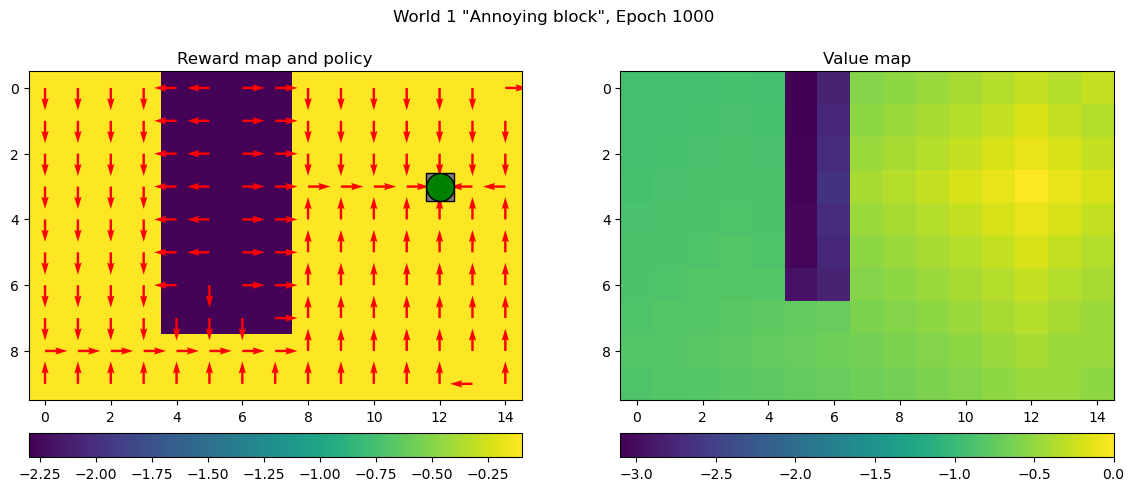

In [9]:
W1 = GridWorld(1)

# --------------------------------------------


Q1 = QLearning(W1, params={"LR": 1, "Gamma": 0.9, "Eps": 0.3, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

Don't forget to run a few tests with the optimized policy to see if the solution looks reasonable.

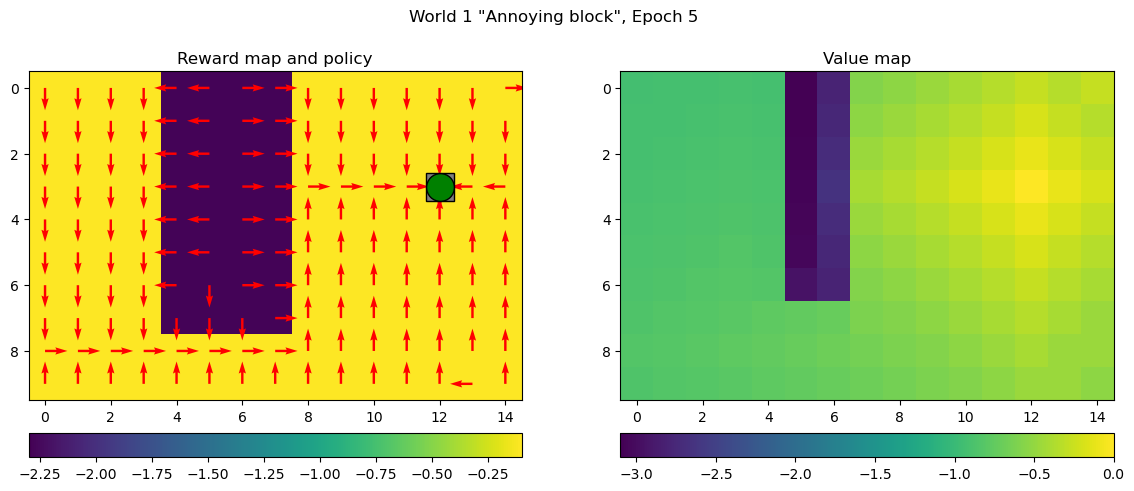

In [10]:
QLearningTest(W=W1, Q=Q1, params={"Epochs": 5, "MaxSteps": 100})

Now continue optimizing worlds 2-4. Note that the optimal hyperparmeters potentially are very different for each world.

### **3.2 GridWorld 2**

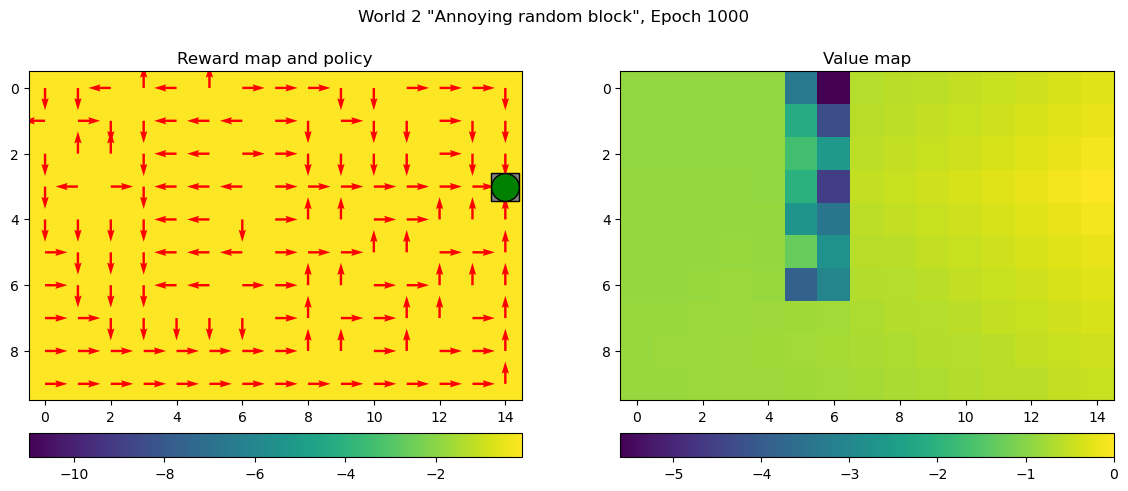

In [11]:
W2 = GridWorld(2)


Q2 = QLearning(W2, params={"LR": 0.2, "Gamma": 0.9, "Eps": 0.5, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

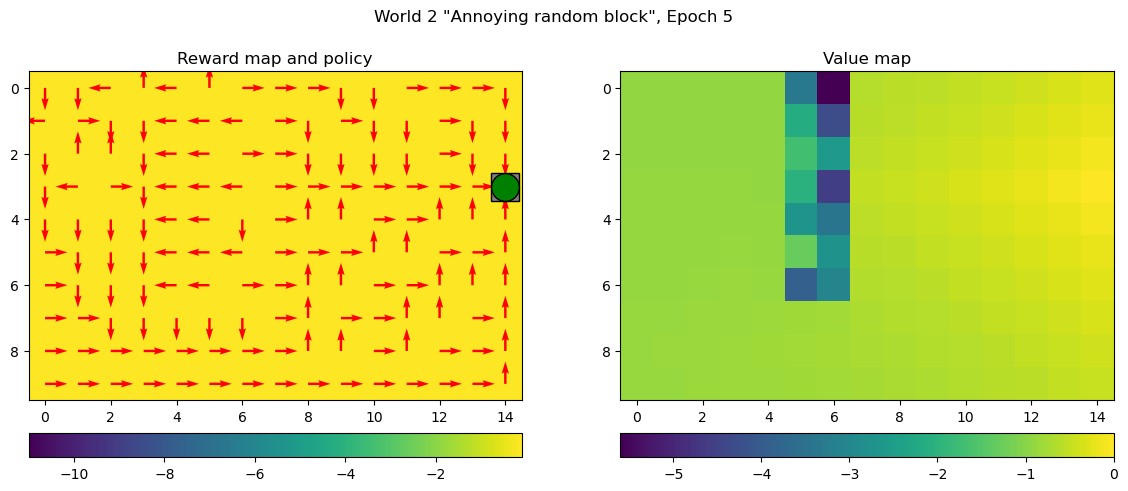

In [12]:
QLearningTest(W=W2, Q=Q2, params={"Epochs": 5, "MaxSteps": 100})

### **3.3 GridWorld 3**

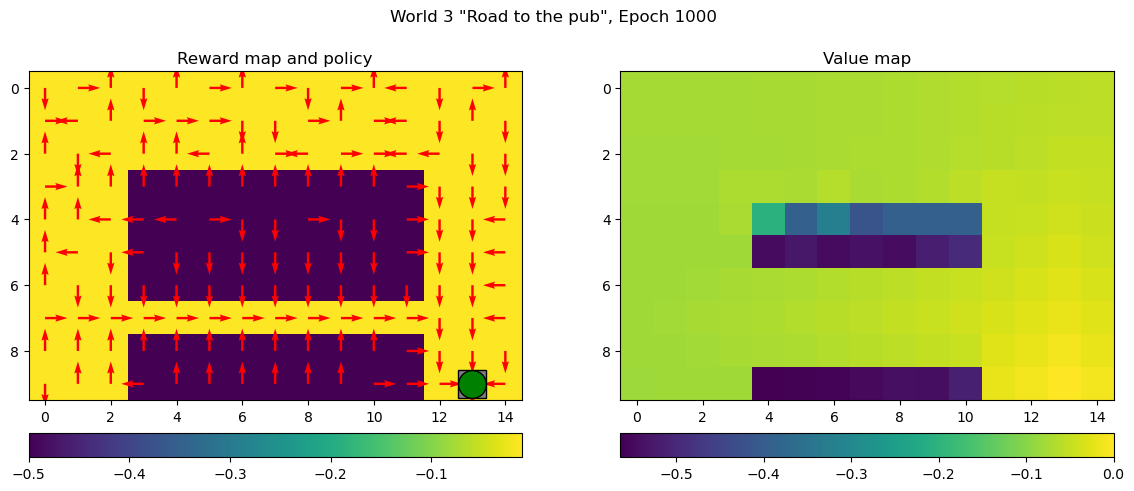

In [13]:
W3 = GridWorld(3)


Q3 = QLearning(W3, params={"LR": .4, "Gamma": 0.9, "Eps": .3, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

Don't forget to run a few tests with the optimized policy to see if the solution looks reasonable.

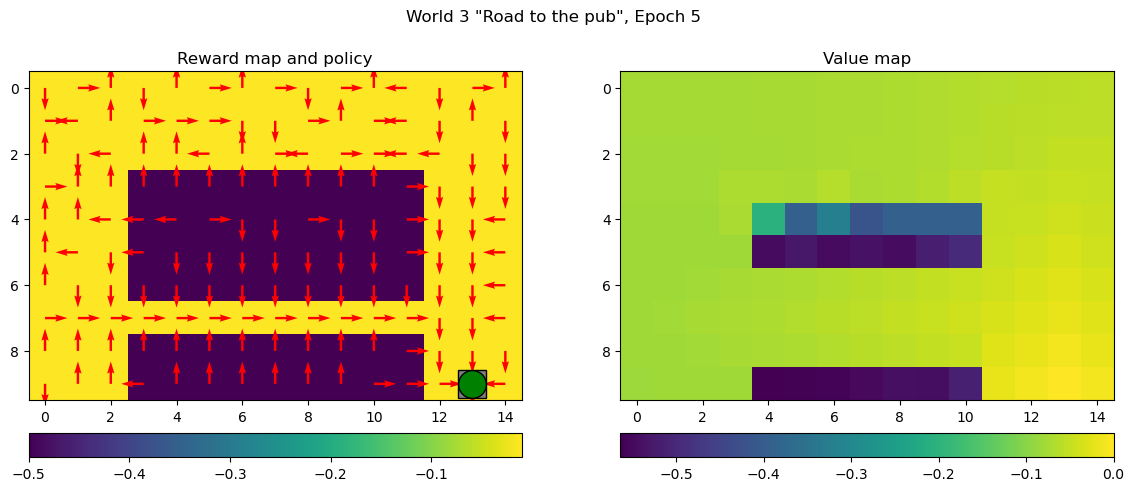

In [14]:
QLearningTest(W=W3, Q=Q3, params={"Epochs": 5, "MaxSteps": 100})

### **3.4 GridWorld 4**

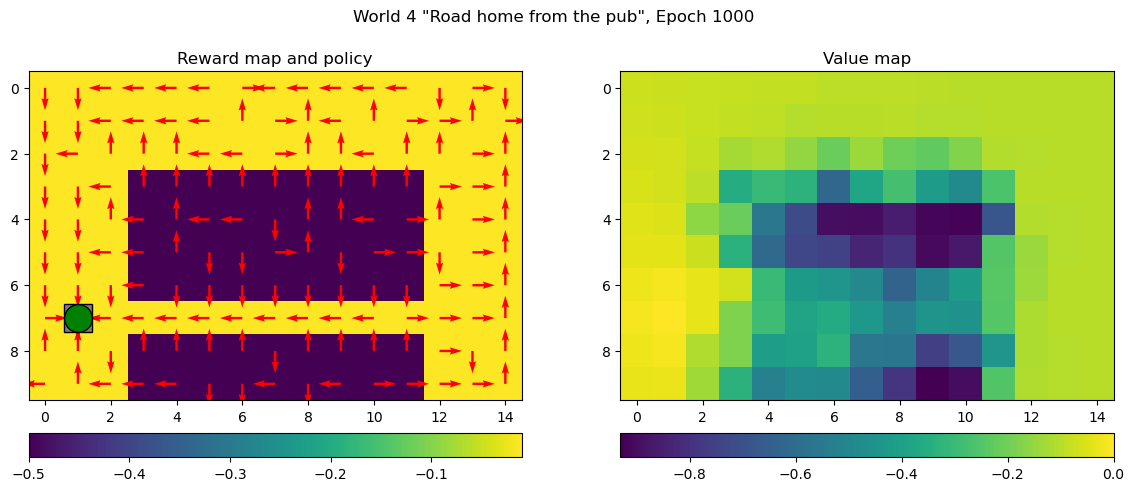

In [15]:
W4 = GridWorld(4)

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q4 = QLearning(W4, params={"LR": .2, "Gamma": 0.9, "Eps": .3, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

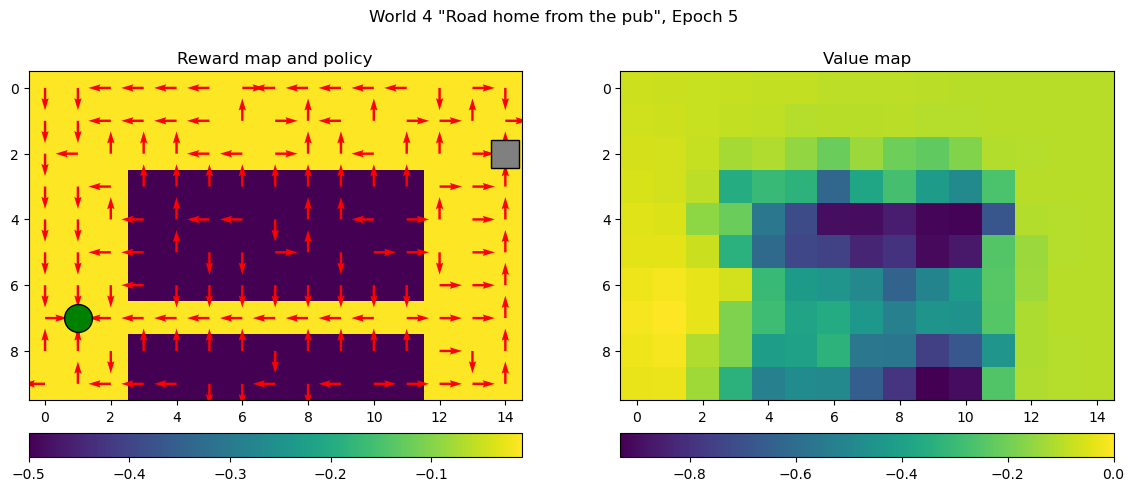

In [16]:
QLearningTest(W=W4, Q=Q4, params={"Epochs": 5, "MaxSteps": 100})

### **4.1 Learning rate**

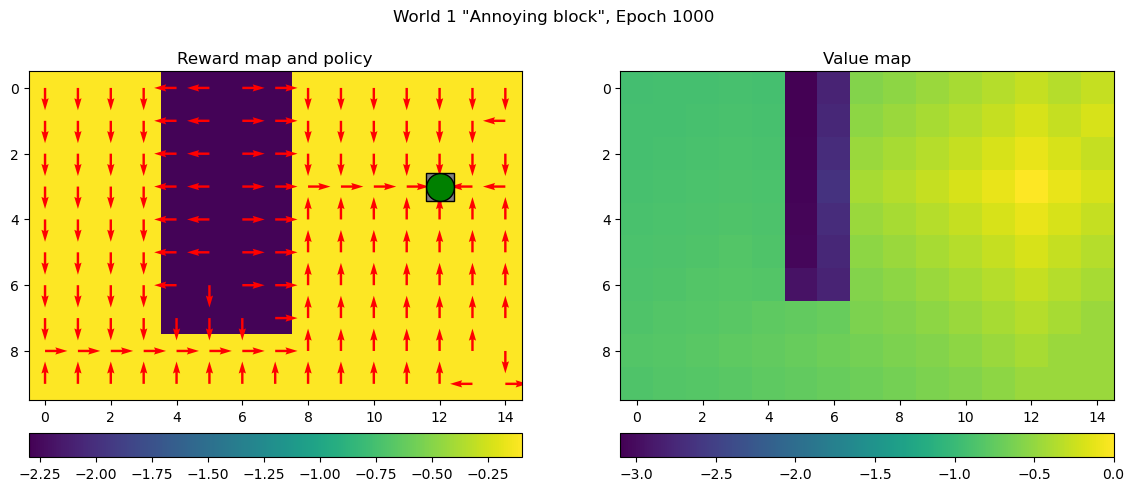

In [17]:

W_LR = GridWorld(1)
Q_41_L = QLearning(W_LR,params={"LR": 1, "Gamma": 0.9, "Eps": .3, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100} )

# ============================================

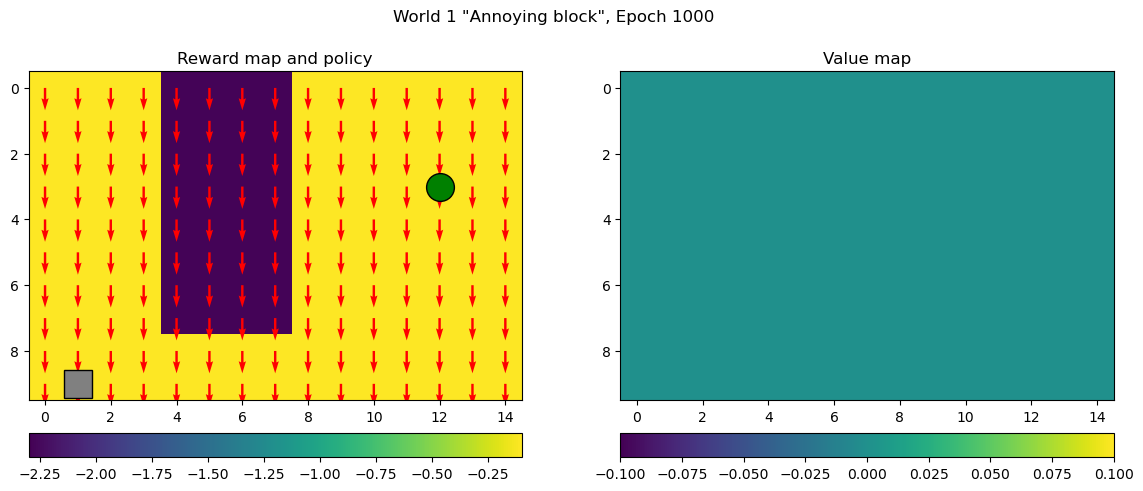

In [18]:


Q_LR_H = QLearning(W_LR, params={"LR": 0, "Gamma": 0.9, "Eps": .3, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

#### **<span style="color:red">Question 6:</span>**
Explain your experiment and results, and why you choose this world (your answers should be based on the output of the cells above).

### **4.2 Discount factor (gamma)**

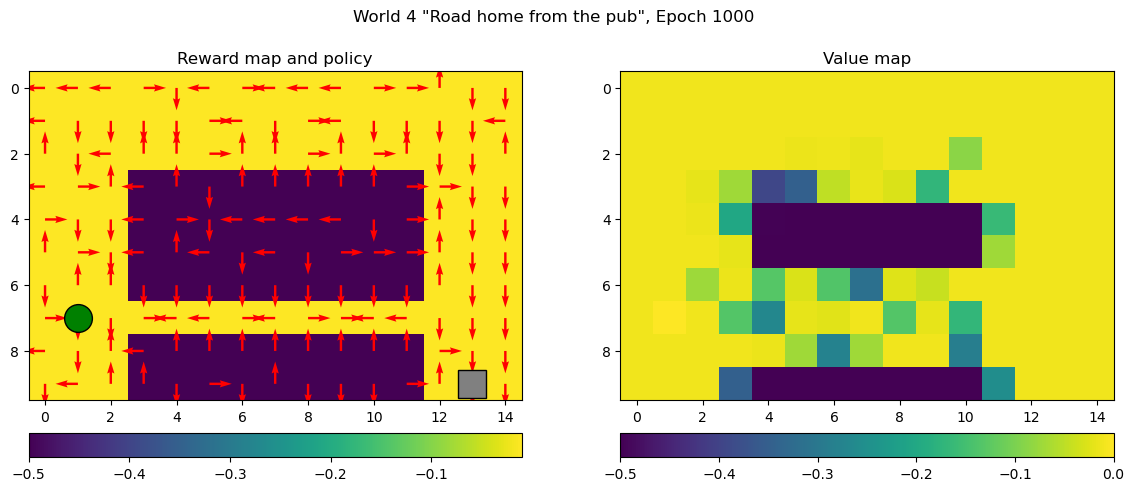

In [19]:


W_DF = GridWorld(4)
Q_DF_L = QLearning(W_DF, params={"LR": .5, "Gamma": 0, "Eps": .3, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

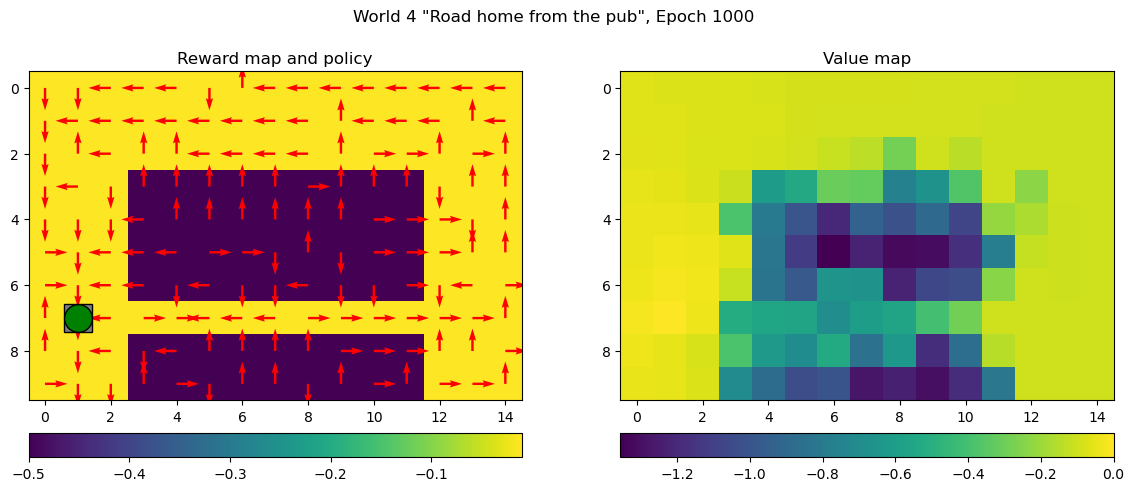

In [20]:


Q_DF_H = QLearning(W_DF, params={"LR": .5, "Gamma": .9, "Eps": .3, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

### **4.3 Exploration rate (epsilon)**

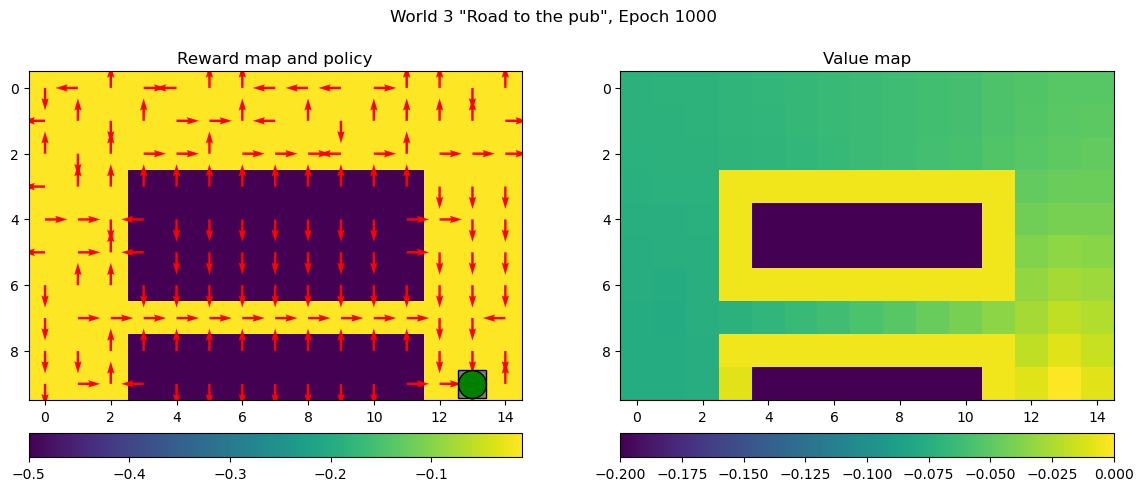

In [21]:

# --------------------------------------------

W_ER = GridWorld(3)
Q_ER_L = QLearning(W_ER, params={"LR": .4, "Gamma": 0.9, "Eps": 0, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

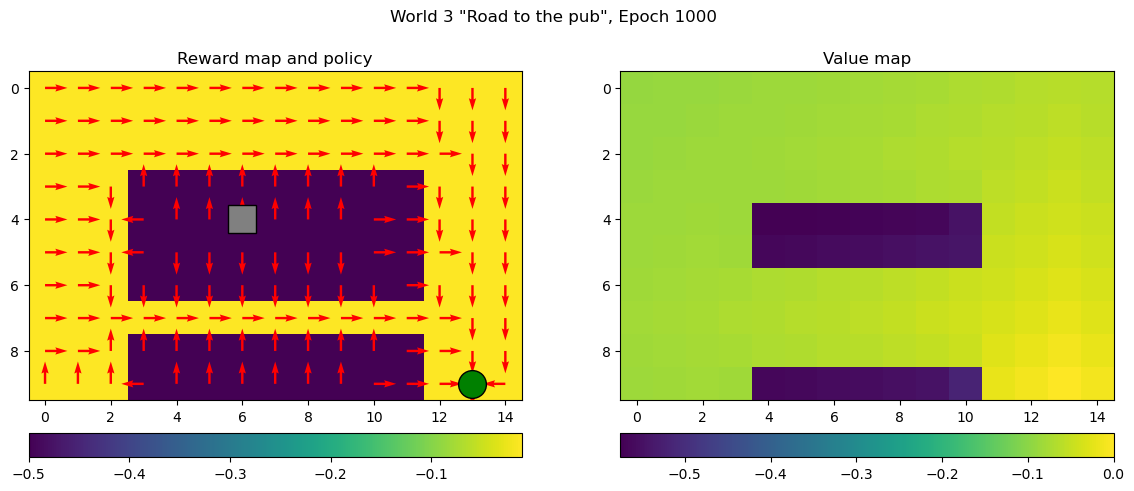

In [22]:


Q_ER_H = QLearning(W_ER,params={"LR": .4, "Gamma": 0.9, "Eps": 1, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

# ============================================